In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os 
import sys
import gget
import xlrd
import textwrap
import nb_util as nb

sys.path.append("../python/")
import utils as ut

# 2015 Data

In [2]:
# load some gene sets
g2_genes = nb.g2_genes
s_genes = nb.s_genes

print(f"{len(g2_genes)=}")
print(f"{len(s_genes)=}")

# get KEGG cell cycle
pid = "hsa04110"
cell_cycle = ut.parseKEGG(pid)
print(f"{len(cell_cycle)=}")

# get circadian genes
pid = "hsa04710"
circadian = ut.parseKEGG(pid)
print(f"{len(circadian)=}")

# get fb_markers

def getGenes(pdf, cellType, ui_upper=None):
    genes = pdf[pdf['cell type'] == cellType]
    if not ui_upper is None:
        genes = genes[genes['ubiquitousness index'] < ui_upper]
    return genes['official gene symbol'].to_list()

pdfPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/panglaodb/pandb.tsv.gz"
pandDf = pd.read_csv(pdfPath, sep="\t")

fb = getGenes(pandDf, 'Fibroblasts')
print(f"{len(fb)=}")

len(g2_genes)=54
len(s_genes)=43
len(cell_cycle)=157
len(circadian)=34
len(fb)=179


In [3]:
print(cell_cycle)

['CCND1', 'CCND2', 'CCND3', 'CDK4', 'CDK6', 'RB1', 'RBL1', 'RBL2', 'ABL1', 'HDAC1', 'HDAC2', 'E2F1', 'E2F2', 'E2F3', 'E2F4', 'E2F5', 'TFDP1', 'TFDP2', 'GSK3B', 'TGFB1', 'TGFB2', 'TGFB3', 'SMAD2', 'SMAD3', 'SMAD4', 'MYC', 'ZBTB17', 'CDKN2A', 'CDKN2B', 'CDKN2C', 'CDKN2D', 'CDKN1B', 'CDKN1C', 'CDKN1A', 'CCNE1', 'CCNE2', 'CDK2', 'SKP1', 'CUL1', 'RBX1', 'SKP2', 'CCNA2', 'CCNA1', 'CDC6', 'CDT1', 'ORC1', 'ORC2', 'ORC3', 'ORC4', 'ORC5', 'ORC6', 'MCM2', 'MCM3', 'MCM4', 'MCM5', 'MCM6', 'MCM7', 'CDC45', 'TICRR', 'MTBP', 'CDC7', 'DBF4', 'DBF4B', 'CDK1', 'CCNB1', 'CCNB2', 'CCNB3', 'CDC25B', 'CDC25C', 'YWHAZ', 'YWHAB', 'YWHAQ', 'YWHAE', 'YWHAH', 'YWHAG', 'PLK1', 'WEE1', 'WEE2', 'PKMYT1', 'CCNH', 'CDK7', 'ANAPC1', 'ANAPC2', 'CDC27', 'ANAPC4', 'ANAPC5', 'CDC16', 'ANAPC7', 'CDC23', 'ANAPC10', 'ANAPC11', 'CDC26', 'ANAPC13', 'ANAPC15', 'ANAPC16', 'CDC20', 'PTTG1', 'PTTG2', 'ESPL1', 'SMC1A', 'SMC1B', 'SMC3', 'RAD21', 'STAG2', 'STAG1', 'ATRX', 'DDX11', 'NIPBL', 'MAU2', 'HDAC8', 'ESCO1', 'ESCO2', 'PDS5A', '

In [4]:
dirpath = "../data/surana_sensor_selection/"


res = []

for f in os.listdir(dirpath):
    fpath = f"{dirpath}{f}"
    if fpath.endswith('.xls') and '2015' in fpath:
        df = pd.read_excel(fpath, sheet_name='Fixed')
        df = df.reset_index(drop=False)
        df = df.rename(columns={'index' : 'rank', 
                                'senSetNameFix' : 'gene_name'})
        df['rank'] = df['rank'] + 1
        df['method'] = f.split("_")[2]
        res.append(df)

df = pd.concat(res)
print(f"{df.shape=}")

df = pd.pivot_table(df, index='gene_name', 
                    columns='method',
                    values='rank').reset_index(drop=False)

df = df.sort_values(by='foldChange')

# add a few useful columns
df['in_both'] = np.where(df[['foldChange', 'raw']].isna().sum(axis=1) == 0, True, False)
df['is_s_phase'] = df['gene_name'].isin(s_genes)
df['is_g2_phase'] = df['gene_name'].isin(g2_genes)
df['is_cell_cycle'] = df['gene_name'].isin(cell_cycle)
df['is_circadian'] = df['gene_name'].isin(circadian)
df['is_fb_marker'] = df['gene_name'].isin(fb)

df.head()

df.shape=(4000, 3)


method,gene_name,foldChange,raw,in_both,is_s_phase,is_g2_phase,is_cell_cycle,is_circadian,is_fb_marker
2773,UBE2C,1.0,46.0,True,False,True,False,False,False
1357,KIF20A,2.0,119.0,True,False,False,False,False,False
1931,PLK1,3.0,97.0,True,False,False,True,False,False
2665,TOP2A,4.0,53.0,True,False,True,False,False,False
419,CDCA3,5.0,96.0,True,False,True,False,False,False


In [5]:
tests = [
    'is_s_phase',
    'is_g2_phase',
    'is_cell_cycle',
    'is_circadian',
    'is_fb_marker',
]

def print_rank_stats(pdf):
    c = ['foldChange', 'raw']
    agdf = pdf[c].agg(['min',
                       'mean', 
                       'median',
                       'max', 
                       'count']).round(1)
    print(agdf.to_string(index_names=False))
    

for column in tests:
    print(f"\n==== {column} ====")
    pdf = df[df[column]]
    print_rank_stats(pdf)


==== is_s_phase ====
        foldChange     raw
min          113.0   103.0
mean         799.1   964.3
median       727.0   891.0
max         1849.0  1998.0
count         35.0    21.0

==== is_g2_phase ====
        foldChange     raw
min            1.0     5.0
mean         102.9   573.4
median        61.0   406.0
max         1101.0  1841.0
count         53.0    46.0

==== is_cell_cycle ====
        foldChange     raw
min            3.0    40.0
mean         599.7   739.6
median       412.5   591.5
max         1957.0  1925.0
count         74.0    54.0

==== is_circadian ====
        foldChange    raw
min          707.0  118.0
mean        1155.8  118.0
median       995.0  118.0
max         1863.0  118.0
count          5.0    1.0

==== is_fb_marker ====
        foldChange     raw
min          226.0   145.0
mean        1029.4   926.4
median      1102.0   862.0
max         1977.0  1825.0
count         14.0    12.0


# PIP-FUCCI Genes

In [6]:
pfGenes = ['PCNA', 'CDT1', 'GMNN', "CDKN1A", "CDK1", ]

test = df[df['gene_name'].isin(pfGenes)]

test[['gene_name', 'foldChange', 'raw']].head()

method,gene_name,foldChange,raw
426,CDK1,11.0,124.0
1858,PCNA,275.0,133.0
443,CDT1,396.0,505.0
435,CDKN1A,719.0,396.0
978,GMNN,1751.0,1932.0


Tue Jan 30 10:02:22 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


../data/surana_sensor_selection/2015_enrichr_ontology_200.csv

==== foldChange ====


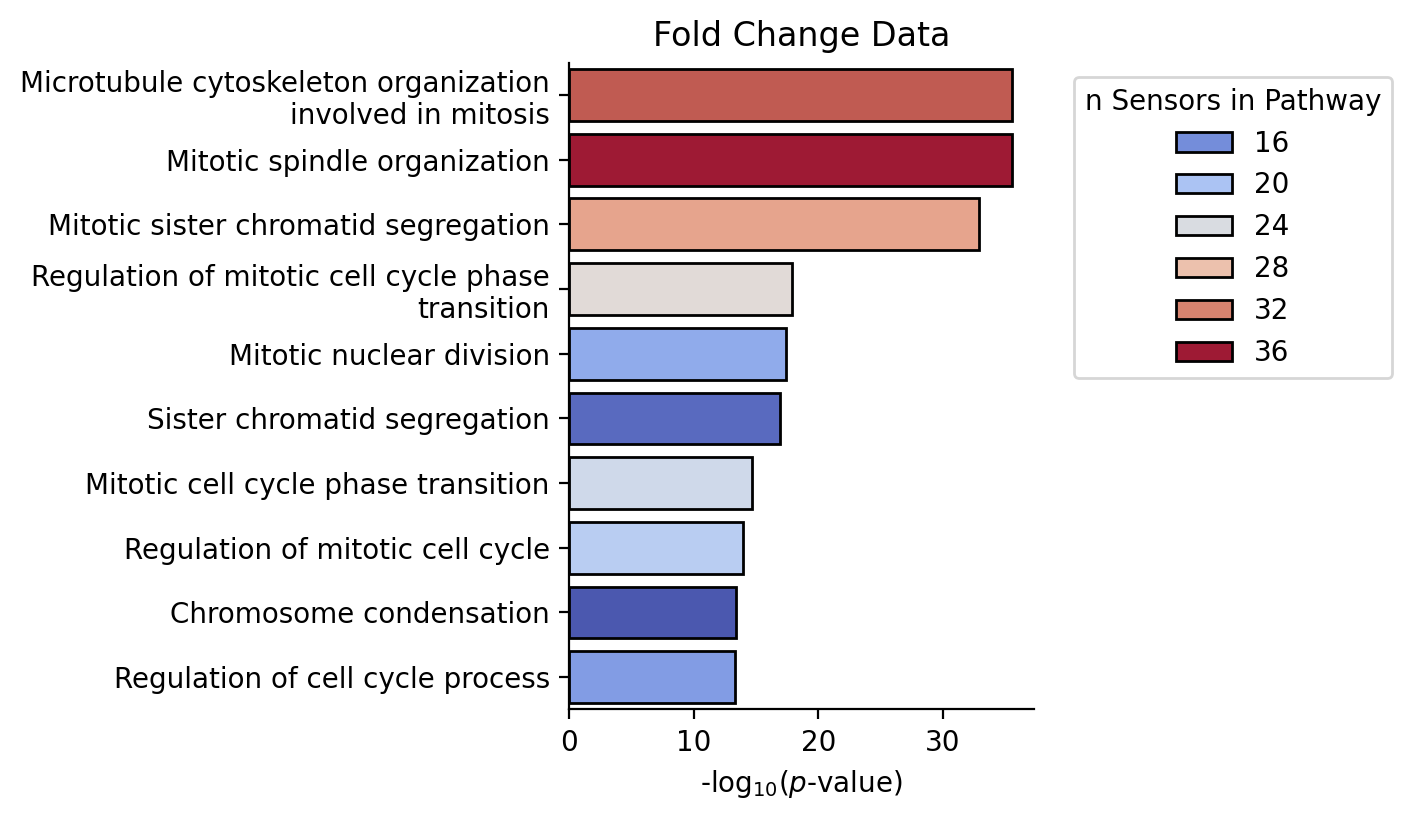

Tue Jan 30 10:02:23 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


                                           path_name     adj_p_val  \
0  microtubule cytoskeleton organization involved...  2.691366e-36   
1          mitotic spindle organization (GO:0007052)  2.691366e-36   
2  mitotic sister chromatid segregation (GO:0000070)  1.141720e-33   
3  regulation of mitotic cell cycle phase transit...  1.174459e-18   
4              mitotic nuclear division (GO:0140014)  4.170288e-18   
5          sister chromatid segregation (GO:0000819)  1.250951e-17   
6   mitotic cell cycle phase transition (GO:0044772)  2.047938e-15   
7      regulation of mitotic cell cycle (GO:0007346)  1.167250e-14   
8               chromosome condensation (GO:0030261)  4.211502e-14   
9      regulation of cell cycle process (GO:0010564)  4.587257e-14   

                                   overlapping_genes  -log10_pval      method  \
0  [BUB1B, CDCA8, TTK, KIF11, CENPA, SKA1, AURKB,...    35.570027  foldChange   
1  [BUB1B, CDCA8, TTK, KIF11, CENPA, SKA1, AURKB,...    35.570027  

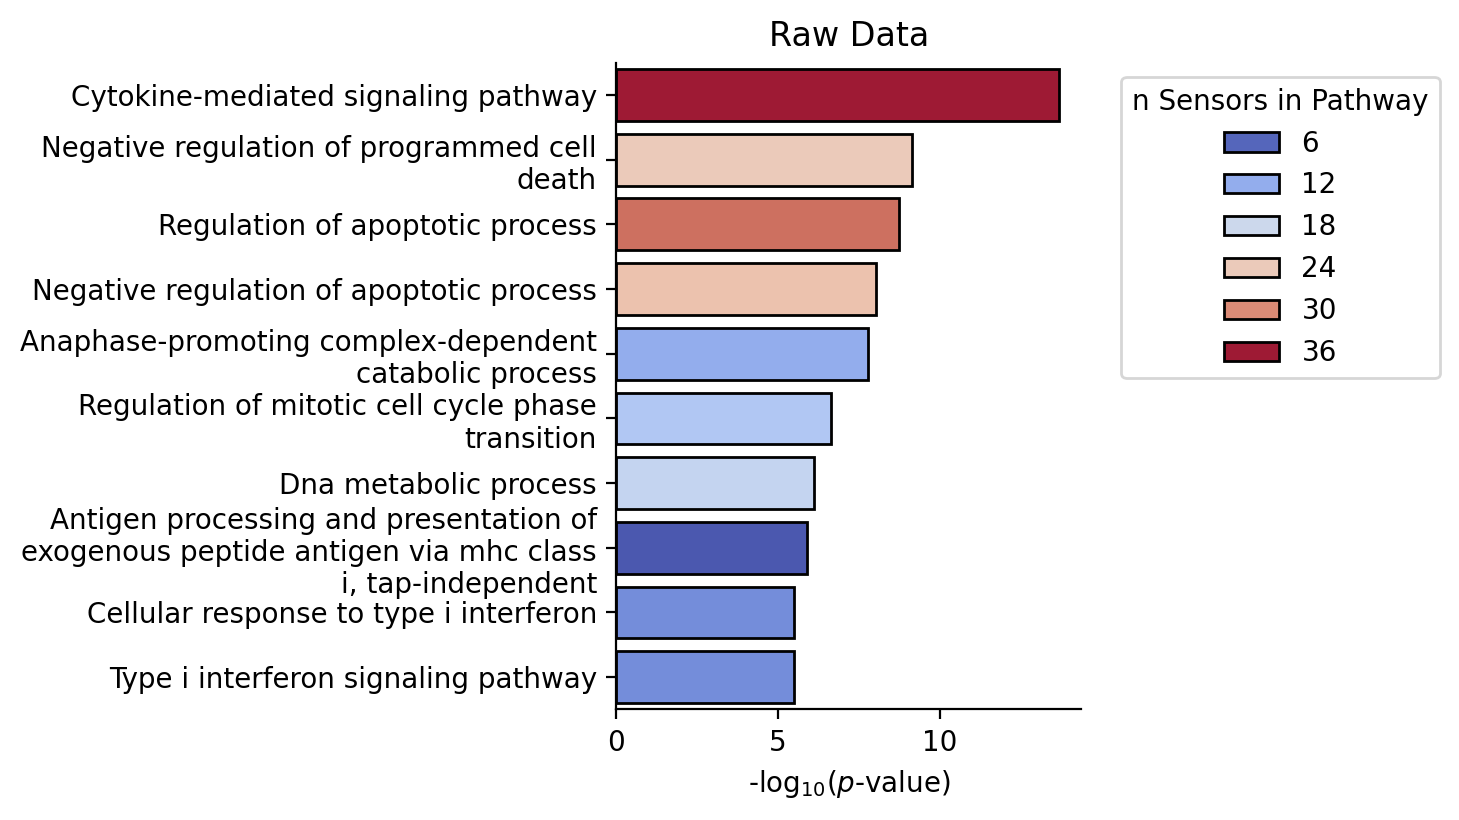

                                           path_name     adj_p_val  \
0   cytokine-mediated signaling pathway (GO:0019221)  2.006203e-14   
1  negative regulation of programmed cell death (...  7.292608e-10   
2       regulation of apoptotic process (GO:0042981)  1.777006e-09   
3  negative regulation of apoptotic process (GO:0...  9.542658e-09   
4  anaphase-promoting complex-dependent catabolic...  1.642981e-08   
5  regulation of mitotic cell cycle phase transit...  2.294247e-07   
6                 DNA metabolic process (GO:0006259)  8.003755e-07   
7  antigen processing and presentation of exogeno...  1.235129e-06   
8  cellular response to type I interferon (GO:007...  3.128349e-06   
9   type I interferon signaling pathway (GO:0060337)  3.128349e-06   

                                   overlapping_genes  -log10_pval method  \
0  [IFITM1, TNFRSF13C, HSP90B1, PSMB4, UBB, HNRNP...    13.697625    raw   
1  [CD74, PRELID1, ARL6IP1, HSPA5, GSTP1, PLK1, L...     9.137117    raw   
2

In [7]:
# get enrichments for each set

database = 'ontology'
alpha = 0.01
n_query = 200
n_plot = 10
outpath = f"../data/surana_sensor_selection/2015_enrichr_{database}_{n_query}.csv"
print(outpath)

def wrap_ylabels(ax, width):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=False))
    ax.set_yticklabels(labels, rotation=0)

titles = ['Fold Change Data', 'Raw Data']

res = []
for i, column in enumerate(['foldChange','raw']):
    print(f"\n==== {column} ====")
    pdf = df.sort_values(by=column)
    query = pdf['gene_name'].head(n_query).to_list()
    edf = gget.enrichr(query, database=database)
    edf = edf[edf['adj_p_val'] <= alpha]
    edf = edf[['path_name', 'adj_p_val', 'overlapping_genes']]
    edf['-log10_pval'] = -1 * np.log10(edf['adj_p_val'])
    edf['method'] = column
    edf['path_name_clean'] = edf['path_name'].apply(lambda x: x.split("(")[0].capitalize())
    edf['n_sensors'] = edf['overlapping_genes'].apply(lambda x: len(x))
    res.append(edf)

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 3, 4.2

    sns.barplot(data=edf.head(n_plot),
                x='-log10_pval',
                y='path_name_clean',
                hue='n_sensors',
                palette='coolwarm',
                dodge=False,
                ec='k')

    plt.title(titles[i])
    plt.ylabel("")
    plt.xlabel(r"-log$_{10}(p$-value)")
    wrap_ylabels(plt.gca(), width=40)
    sns.move_legend(plt.gca(), 
                    title='n Sensors in Pathway',
                    loc='upper right',
                    bbox_to_anchor=(1.8, 1))
    sns.despine()
    plt.show()
    print(edf.head(n_plot))
        
res = pd.concat(res)
res.to_csv(outpath, index=False)

# 2018 Data Fixed

In [8]:
# get myogenic genes
mg_cells = ['Myoblasts', 'Myofibroblasts', 'Myocytes']
myo = []

for mg in mg_cells:
    myo += getGenes(pandDf, mg)

myo = list(set(myo))
print(f"{len(myo)=}")

len(myo)=117


In [9]:
dirpath = "../data/surana_sensor_selection/"


res = []

for f in os.listdir(dirpath):
    fpath = f"{dirpath}{f}"
    if fpath.endswith('.xls') and '2018' in fpath:
        df = pd.read_excel(fpath, sheet_name='Fixed')
        df = df.reset_index(drop=False)
        df = df.rename(columns={'index' : 'rank', 
                                'senSetNameFix' : 'gene_name'})
        df['rank'] = df['rank'] + 1
        df['method'] = f.split("_")[2]
        res.append(df)

df = pd.concat(res)
print(f"{df.shape=}")

df = pd.pivot_table(df, index='gene_name', 
                    columns='method',
                    values='rank').reset_index(drop=False)
df.head()
df = df.sort_values(by='foldChange')

# add a few useful columns
df['in_both'] = np.where(df[['foldChange', 'raw']].isna().sum(axis=1) == 0, True, False)
df['is_fb_marker'] = df['gene_name'].isin(fb)
df['is_myo_marker'] = df['gene_name'].isin(myo)

df.head()

df.shape=(4000, 3)


method,gene_name,foldChange,raw,in_both,is_fb_marker,is_myo_marker
643,CXCL2,1.0,20.0,True,False,False
612,CSF3,2.0,195.0,True,False,False
26,ACTC1,3.0,55.0,True,False,True
1246,HSPA1B,4.0,31.0,True,False,False
2356,SCD,5.0,168.0,True,False,False


In [10]:
tests = [
    'is_myo_marker',
    'is_fb_marker',
]

def print_rank_stats(pdf):
    c = ['foldChange', 'raw']
    agdf = pdf[c].agg(['min',
                       'mean', 
                       'median',
                       'max', 
                       'count']).round(1)
    print(agdf.to_string(index_names=False))
    

for column in tests:
    print(f"\n==== {column} ====")
    pdf = df[df[column]]
    print_rank_stats(pdf)


==== is_myo_marker ====
        foldChange     raw
min            3.0    32.0
mean         621.6   737.9
median       464.0   685.0
max         1827.0  1884.0
count         23.0    21.0

==== is_fb_marker ====
        foldChange     raw
min           10.0     3.0
mean         791.4   683.2
median       684.5   513.0
max         1966.0  1996.0
count         48.0    68.0


In [11]:
genes = [
    'Six1',
    'Six4',
    'Pax3',
    'Pax7',
    'Myf5',
    'Myod',
    'Myog',
    'Mrf4',
]

genes = [x.upper() for x in genes]

pdf = df[df['gene_name'].isin(genes)]
pdf['gene_name'].value_counts()

gene_name
SIX1    1
SIX4    1
Name: count, dtype: int64

In [18]:
print(genes)

['SIX1', 'SIX4', 'PAX3', 'PAX7', 'MYF5', 'MYOD', 'MYOG', 'MRF4']


Tue Jan 30 10:02:24 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


../data/surana_sensor_selection/2018_enrichr_ontology_100.csv

==== foldChange ====


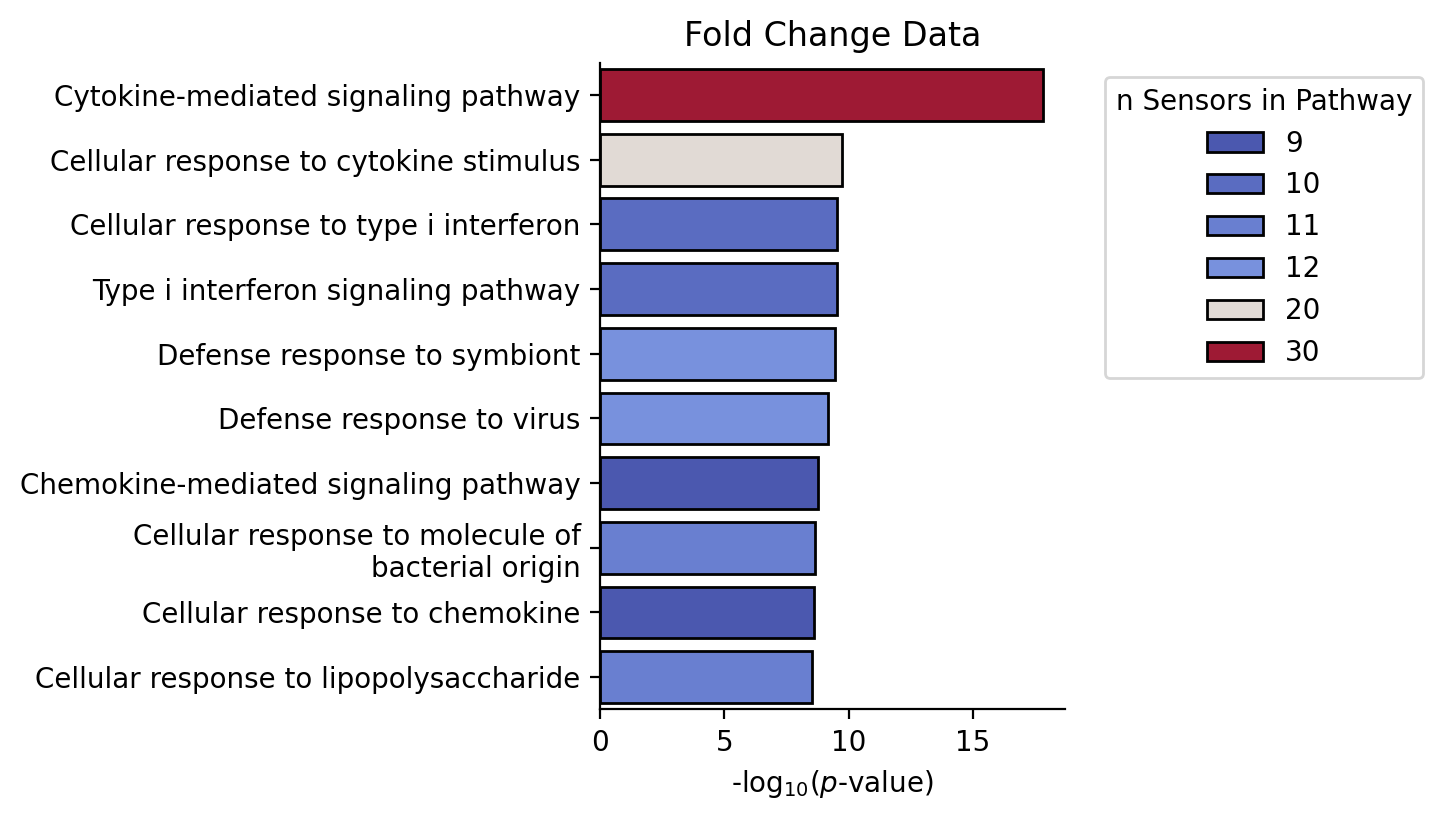

Tue Jan 30 10:02:24 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


                                           path_name     adj_p_val  \
0   cytokine-mediated signaling pathway (GO:0019221)  1.553182e-18   
1  cellular response to cytokine stimulus (GO:007...  1.865903e-10   
2  cellular response to type I interferon (GO:007...  3.068475e-10   
3   type I interferon signaling pathway (GO:0060337)  3.068475e-10   
4          defense response to symbiont (GO:0140546)  3.474616e-10   
5             defense response to virus (GO:0051607)  6.723295e-10   
6  chemokine-mediated signaling pathway (GO:0070098)  1.684408e-09   
7  cellular response to molecule of bacterial ori...  2.247847e-09   
8        cellular response to chemokine (GO:1990869)  2.514812e-09   
9  cellular response to lipopolysaccharide (GO:00...  2.874022e-09   

                                   overlapping_genes  -log10_pval      method  \
0  [CSF3, IFITM1, CXCL8, CEBPD, IL24, IFI6, CXCL1...    17.808778  foldChange   
1  [CSF3, CXCL8, CEBPD, DUSP1, IL1R1, IL24, LIF, ...     9.729111  

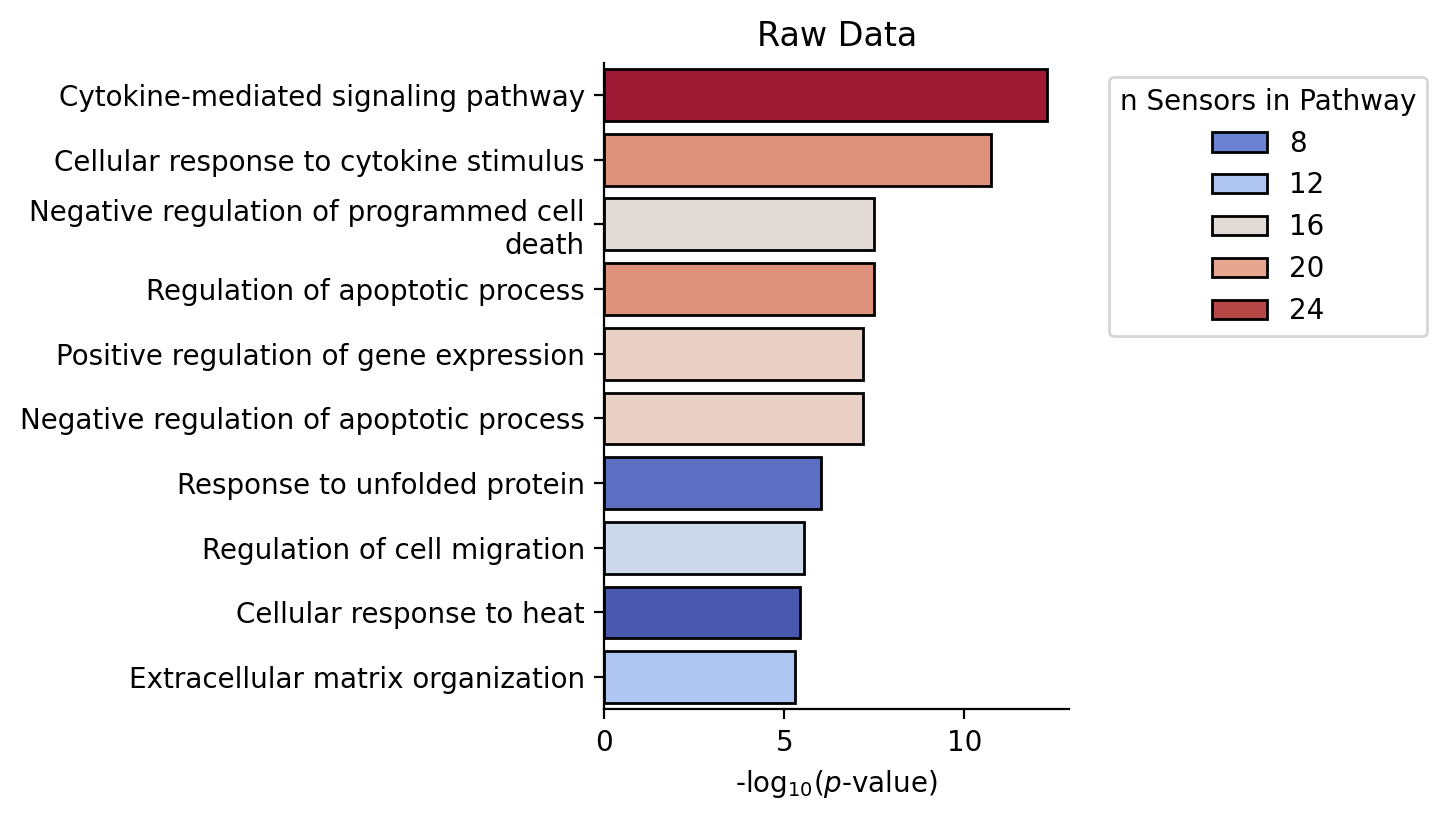

                                           path_name     adj_p_val  \
0   cytokine-mediated signaling pathway (GO:0019221)  4.966505e-13   
1  cellular response to cytokine stimulus (GO:007...  1.753950e-11   
2  negative regulation of programmed cell death (...  3.223956e-08   
3       regulation of apoptotic process (GO:0042981)  3.223956e-08   
4  positive regulation of gene expression (GO:001...  6.659727e-08   
5  negative regulation of apoptotic process (GO:0...  6.659727e-08   
6          response to unfolded protein (GO:0006986)  9.523898e-07   
7          regulation of cell migration (GO:0030334)  2.837830e-06   
8             cellular response to heat (GO:0034605)  3.756504e-06   
9     extracellular matrix organization (GO:0030198)  4.926403e-06   

                                   overlapping_genes  -log10_pval method  \
0  [CXCL8, CXCL1, CXCL3, CXCL2, SOCS3, MT2A, UBB,...    12.303949    raw   
1  [HSPA8, IL11, CXCL8, DUSP1, MMP1, MMP3, FN1, C...    10.755983    raw   
2

In [12]:
# get enrichments for each set

database = 'ontology'
alpha = 0.01
n_query = 100
n_plot = 10
outpath = f"../data/surana_sensor_selection/2018_enrichr_{database}_{n_query}.csv"
print(outpath)

def wrap_ylabels(ax, width):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=False))
    ax.set_yticklabels(labels, rotation=0)

titles = ['Fold Change Data', 'Raw Data']

res = []
for i, column in enumerate(['foldChange','raw']):
    print(f"\n==== {column} ====")
    pdf = df.sort_values(by=column)
    query = pdf['gene_name'].head(n_query).to_list()
    edf = gget.enrichr(query, database=database)
    edf = edf[edf['adj_p_val'] <= alpha]
    edf = edf[['path_name', 'adj_p_val', 'overlapping_genes']]
    edf['-log10_pval'] = -1 * np.log10(edf['adj_p_val'])
    edf['method'] = column
    edf['path_name_clean'] = edf['path_name'].apply(lambda x: x.split("(")[0].capitalize())
    edf['n_sensors'] = edf['overlapping_genes'].apply(lambda x: len(x))
    res.append(edf)

    plt.rcParams['figure.dpi'] = 200
    plt.rcParams['figure.figsize'] = 3, 4.2

    sns.barplot(data=edf.head(n_plot),
                x='-log10_pval',
                y='path_name_clean',
                hue='n_sensors',
                palette='coolwarm',
                dodge=False,
                ec='k')

    plt.title(titles[i])
    plt.ylabel("")
    plt.xlabel(r"-log$_{10}(p$-value)")
    wrap_ylabels(plt.gca(), width=40)
    sns.move_legend(plt.gca(), 
                    title='n Sensors in Pathway',
                    loc='upper right',
                    bbox_to_anchor=(1.8, 1))
    sns.despine()
    plt.show()
    print(edf.head(n_plot))
        
res = pd.concat(res)
res.to_csv(outpath, index=False)

# 2018 time-varying sensors

In [13]:
dirpath = "../data/surana_sensor_selection/"


res = []

for f in os.listdir(dirpath):
    fpath = f"{dirpath}{f}"
    if fpath.endswith('.xls') and '2018' in fpath:
        df = pd.read_excel(fpath, sheet_name='TimeVarying')
        df = df.reset_index(drop=False)
        df = df.rename(columns={'index' : 'rank', 
                                'senSetNameFix' : 'gene_name'})
        df['rank'] = df['rank'] + 1
        df['method'] = f.split("_")[2]
        df = pd.melt(df, id_vars=['method', 'rank'], 
                     value_name='gene_name', var_name='time')
        res.append(df)

df = pd.concat(res)
print(f"{df.shape=}")

# add a few useful columns
df['is_fb_marker'] = df['gene_name'].isin(fb)
df['is_myo_marker'] = df['gene_name'].isin(myo)
df['time_int'] = df['time'].str.replace("hr", "").astype(int)

df.head()

df.shape=(60000, 4)


,method,rank,time,gene_name,is_fb_marker,is_myo_marker,time_int
0,foldChange,1,0 hr,CXCL2,False,False,0
1,foldChange,2,0 hr,CSF3,False,False,0
2,foldChange,3,0 hr,ACTC1,False,True,0
3,foldChange,4,0 hr,HSPA1B,False,False,0
4,foldChange,5,0 hr,SCD,False,False,0


,method,time_int,n_fb,n_myo
0,foldChange,0,44,27
1,foldChange,8,44,27
2,foldChange,16,44,20
3,foldChange,24,39,23
4,foldChange,32,49,22


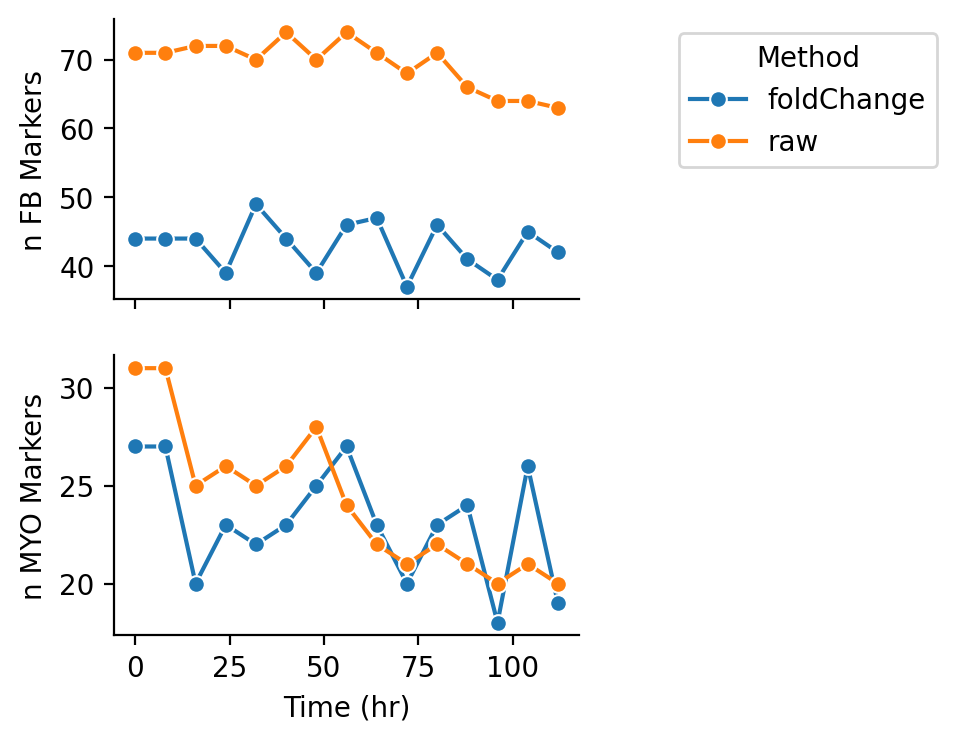

In [14]:
gx = df.groupby(['method', 'time_int']).agg(
    n_fb = ('is_fb_marker', 'sum'),
    n_myo = ('is_myo_marker', 'sum'),
).reset_index(drop=False)


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 4
fog, axs = plt.subplots(2, 1, sharex=True)

sns.lineplot(data=gx,
             x='time_int',
             y='n_fb',
             marker="o",
             hue='method',
             ax=axs[0])

axs[0].set_ylabel("n FB Markers")
sns.move_legend(axs[0], 
                loc='upper right',
                title='Method',
                bbox_to_anchor=(1.8, 1))

sns.lineplot(data=gx,
             x='time_int',
             y='n_myo',
             marker="o",
             hue='method',
             ax=axs[1])

axs[1].set_ylabel("n MYO Markers")
axs[1].legend().remove()
axs[1].set_xlabel("Time (hr)")

sns.despine()

gx.head()

# Building a muscle results

In [15]:
genes = [
    'Six1',
    'Six4',
    'Pax3',
    'Pax7',
    'Myf5',
    'Myod',
    'Myog',
    'Mrf4',
]

genes = [x.upper() for x in genes]

pdf = df[df['gene_name'].isin(genes)]
pdf['gene_name'].value_counts()

gene_name
SIX4    24
SIX1    21
Name: count, dtype: int64

# enrichment results by time

In [19]:
# get enrichments for each set

database = 'ontology'
alpha = 0.01
n_query = 100
n_plot = 10
outpath = f"../data/surana_sensor_selection/2018_time_enrichr_{database}_{n_query}.csv"
print(outpath)

def wrap_ylabels(ax, width):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=False))
    ax.set_yticklabels(labels, rotation=0)

titles = ['Fold Change Data', 'Raw Data']

res = []

for i, (groupers, group) in enumerate(df.groupby(['method', 'time_int'])): 
    method, t = groupers
    print(f"\n==== {method}: {t=} ====")
    group = group.sort_values(by='rank')

    query = group['gene_name'].head(n_query).to_list()
    
    edf = gget.enrichr(query, database=database)
    edf = edf[edf['adj_p_val'] <= alpha]
    edf = edf[['path_name', 'adj_p_val', 'overlapping_genes']]
    edf['-log10_pval'] = -1 * np.log10(edf['adj_p_val'])
    edf['method'] = method
    edf['time_int'] = t

    edf['path_name_clean'] = edf['path_name'].apply(lambda x: x.split("(")[0].capitalize())
    edf['n_sensors'] = edf['overlapping_genes'].apply(lambda x: len(x))
    res.append(edf)

res = pd.concat(res)
res.to_csv(outpath, index=False)
res.head()

Tue Jan 30 10:14:44 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


../data/surana_sensor_selection/2018_time_enrichr_ontology_100.csv

==== foldChange: t=0 ====


Tue Jan 30 10:14:44 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== foldChange: t=8 ====


Tue Jan 30 10:14:44 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== foldChange: t=16 ====


Tue Jan 30 10:14:45 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== foldChange: t=24 ====


Tue Jan 30 10:14:45 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== foldChange: t=32 ====


Tue Jan 30 10:14:45 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== foldChange: t=40 ====


Tue Jan 30 10:14:46 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== foldChange: t=48 ====


Tue Jan 30 10:14:46 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== foldChange: t=56 ====


Tue Jan 30 10:14:46 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== foldChange: t=64 ====


Tue Jan 30 10:14:47 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== foldChange: t=72 ====


Tue Jan 30 10:14:47 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== foldChange: t=80 ====


Tue Jan 30 10:14:47 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== foldChange: t=88 ====


Tue Jan 30 10:14:48 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== foldChange: t=96 ====


Tue Jan 30 10:14:48 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== foldChange: t=104 ====


Tue Jan 30 10:14:48 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== foldChange: t=112 ====


Tue Jan 30 10:14:49 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== raw: t=0 ====


Tue Jan 30 10:14:49 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== raw: t=8 ====


Tue Jan 30 10:14:50 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== raw: t=16 ====


Tue Jan 30 10:14:50 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== raw: t=24 ====


Tue Jan 30 10:14:50 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== raw: t=32 ====


Tue Jan 30 10:14:51 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== raw: t=40 ====


Tue Jan 30 10:14:51 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== raw: t=48 ====


Tue Jan 30 10:14:51 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== raw: t=56 ====


Tue Jan 30 10:14:52 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== raw: t=64 ====


Tue Jan 30 10:14:52 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== raw: t=72 ====


Tue Jan 30 10:14:52 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== raw: t=80 ====


Tue Jan 30 10:14:53 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== raw: t=88 ====


Tue Jan 30 10:14:53 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== raw: t=96 ====


Tue Jan 30 10:14:53 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== raw: t=104 ====


Tue Jan 30 10:14:54 2024 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    



==== raw: t=112 ====


,path_name,adj_p_val,overlapping_genes,-log10_pval,method,time_int,path_name_clean,n_sensors
0,cytokine-mediated signaling pathway (GO:0019221),5.070216e-11,"[CSF3, CXCL8, CEBPD, IL1R1, IL24, LIF, ISG15, ...",10.294974,foldChange,0,Cytokine-mediated signaling pathway,23
1,cellular response to cytokine stimulus (GO:007...,1.837874e-10,"[CSF3, CXCL8, CEBPD, DUSP1, IL1R1, IL24, LIF, ...",9.735684,foldChange,0,Cellular response to cytokine stimulus,20
2,secondary alcohol biosynthetic process (GO:190...,1.038836e-07,"[IDI1, HMGCS1, INSIG1, MSMO1, DHCR24, HMGCR, D...",6.983453,foldChange,0,Secondary alcohol biosynthetic process,7
3,chemokine-mediated signaling pathway (GO:0070098),1.038836e-07,"[CXCL8, RBM15, CCL8, CCL7, CCL2, CXCL1, CXCL3,...",6.983453,foldChange,0,Chemokine-mediated signaling pathway,8
4,cholesterol biosynthetic process (GO:0006695),1.038836e-07,"[IDI1, HMGCS1, INSIG1, MSMO1, DHCR24, HMGCR, D...",6.983453,foldChange,0,Cholesterol biosynthetic process,7


In [17]:
res['path_name'].value_counts()

path_name
cytokine-mediated signaling pathway (GO:0019221)                                                              30
cellular response to cytokine stimulus (GO:0071345)                                                           30
negative regulation of cell population proliferation (GO:0008285)                                             30
regulation of extrinsic apoptotic signaling pathway in absence of ligand (GO:2001239)                         30
positive regulation of nucleotide-binding oligomerization domain containing signaling pathway (GO:0070426)    30
                                                                                                              ..
negative regulation of MAP kinase activity (GO:0043407)                                                        2
positive regulation of programmed cell death (GO:0043068)                                                      1
positive regulation of macromolecule biosynthetic process (GO:0010557)                